In [1]:
import os
import sys
import random
import datetime
import glob
from itertools import combinations
import matplotlib.pyplot as plt
from evaluate_dialogue import contrast_set_actors, get_scene_context, load_dialogues_for_variant
from generate_dialogue import generate_dialogue, collect_game_scenes
from dataclasses import dataclass
from typing import Any
from dotenv import load_dotenv
from langchain_core.language_models.llms import LLM
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from iconic_tools.langchain import (
    InstructSonnet,
    InstructOpus3,
    InstructGPT4,
    InstructO1,
    InstructGeminiPro,
    InstructGeminiFlash,
    InstructGeminiFlash2,
    InstructGPT35,
)

c:\Users\borru\LocalStudios\Venvs\antdemo-server\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate Multiple Dialogues
Create a function that generates multiple dialogues for each scene using a specified model and number of repetitions. The dialogues will be saved in appropriate folders.

In [2]:
def get_llm_model(name: str, temperature: float, max_tokens: int) -> LLM:
    model_map = {
        'Sonnet': InstructSonnet,
        'Opus3': InstructOpus3,
        'GPT4': InstructGPT4,
        # 'O1': InstructO1, # O1 is not available to use temperature and max_tokens
        'GeminiPro': InstructGeminiPro,
        'GeminiFlash': InstructGeminiFlash,
        'GeminiFlash2': InstructGeminiFlash2,
        'GPT35': InstructGPT35
    }
    
    if name not in model_map:
        raise ValueError(f"Model {name} not found. Available models: {list(model_map.keys())}")
    
    return model_map[name](temperature=temperature, max_tokens=max_tokens)

In [3]:
def generate_multiple_dialogues(model: LLM, repetitions: int) -> None:
    scenes = collect_game_scenes()
    for _ in range(repetitions):
        for act in scenes:
            game = list(act.keys())[0]  # Set global GAME
            for scene in act[game]:
                generate_dialogue(
                    get_llm_model(model, 1.0, 3000),
                    get_llm_model(model, 0.0, 500),
                    get_llm_model(model, 1.0, 3000),
                    scene,
                    game,
                    35,
                )

In [4]:
# First experiment will be contrasting flash, flas2 and sonnet

models = ['GeminiFlash2', 'Sonnet']
repetitions = 3
for model in models:
    generate_multiple_dialogues(model, repetitions)



Eliza: Shit! The error is spreading like wildfire! These signals are off the charts! I need a full description of what is happening in the room NOW!
Player: The red lights are flashing, there's a klaxon blaring, and...and those maintenance drones are falling out of the void like flies. Plus, fires are breaking out around some of the pods!

Eliza: Falling drones, fires, alarms... Fuck! This is worse than I thought. Can you see what's causing the fires? Are they spreading quickly?

Player: I don't know what's causing them, but yeah, they're spreading fast! And the spinning decks have stopped!

Eliza: Stopped spinning? That's the gravity drive failing. Okay, okay... think, Eliza, think!

Player: It's chaos here, Eliza! Just... just total chaos.

Eliza: Multi-system failure cascade... just as I feared. Alright, listen carefully: there's no time to save that engineer now. The priority is to regain control of the ship. You need to get to the control room. Do you know how to get there?

Mini 

# Evaluation

In [2]:
def compare_models_in_scene(evaluation_model: LLM, scene_link: str, model_a: str, model_b: str, evaluated_actors: str = "Eliza") -> None:
    """Compare performance between two models' dialogues for a given scene.
       The scene_link input must be in the format "act/scene".
       This function loads the complete scene context and uses it in the evaluation.
    """
    scene_context = get_scene_context(scene_link)
    set_actor_1 = load_dialogues_for_variant(scene_link, model_a)
    set_actor_2 = load_dialogues_for_variant(scene_link, model_b)
    result = contrast_set_actors(
        evaluation_model,
        set_actor_1,
        set_actor_2,
        scene_context,
        evaluated_actors
    )
    print(f"Comparison result between {model_a} and {model_b}:", result)

EVALUATION_MODEL = InstructSonnet(temperature=0.0, max_tokens=5000)
scene = "act_1/find_exit"

In [ ]:
scene = "act_1/find_exit"
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructGeminiFlash", "InstructGeminiFlash2") # Winned by Flash2 3-0

Comparison result between InstructGeminiFlash and InstructGeminiFlash2: {'review': "First set of actors:\nGood points:\n- Consistent portrayal of Eliza as supportive and encouraging\n- Maintained a sense of urgency throughout the dialogue\n- Incorporated humor to lighten the tense situation\n\nBad points:\n- Lacked depth in character development\n- Missed opportunities for more detailed descriptions of the environment\n- Limited exploration of the player's background or motivations\n\nSecond set of actors:\nGood points:\n- Provided more detailed and vivid descriptions of the environment\n- Explored the player's background and role on the ship\n- Eliza showed more depth and vulnerability in her character\n\nBad points:\n- Some inconsistencies in Eliza's knowledge of the ship's layout\n- Occasional breaks in the sense of urgency\n\nContrasting the two sets:\nThe second set of actors demonstrated superior character development and world-building. They provided richer descriptions of the e

In [ ]:
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructGeminiFlash2", "InstructSonnet") # Winned by Flash2 3-0;

Comparison result between InstructGeminiFlash2 and InstructSonnet: {'review': "Good points for the first set of actors: Eliza provides detailed instructions, maintains a calm and reassuring tone, and engages in natural conversation to keep the player focused. She also adapts well to the player's responses and provides contextual information about herself when asked. Bad points for the first set of actors: Eliza occasionally gets sidetracked with unnecessary details and doesn't always keep the focus on the immediate task at hand.\n\nGood points for the second set of actors: Eliza gives clear, concise instructions and consistently guides the player towards the exit. She maintains a professional demeanor while still showing empathy and concern for the player's well-being. Eliza also provides relevant information about the situation on other ships when asked. Bad points for the second set of actors: Eliza's responses sometimes lack the depth and personal touch present in the first set.\n\n

In [ ]:
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructSonnet", "InstructGeminiFlash2") # 1-2; Winned by Flash

Comparison result between InstructSonnet and InstructGeminiFlash2: {'review': "Good points for the first set of actors: Consistent and detailed responses, maintaining the atmosphere of urgency and danger. Good at providing clear instructions and responding to the player's observations. Eliza shows empathy and encourages the player effectively.\n\nGood points for the second set of actors: More creative and colorful language, with vivid descriptions and metaphors. Eliza has a distinct personality, using humor and sarcasm to lighten the mood. The dialogue feels more natural and conversational.\n\nBad points for the first set: Sometimes overly formal and less engaging. Lacks the personal touch and humor present in the second set.\n\nBad points for the second set: Occasionally strays from the main objective, getting sidetracked by personal conversations. Some responses could be more concise and focused on the task at hand.\n\nContrasting the two sets, the first maintains a more serious and 

In [15]:
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructGeminiFlash", "InstructSonnet") # Winned by Sonnet 2-0

Comparison result between InstructGeminiFlash and InstructSonnet: {'review': "Good points for the first set of actors: They maintain a consistent tone throughout the dialogue, balancing urgency with moments of levity. They effectively guide the player through the scene, providing clear instructions and feedback. The actors show adaptability to different player responses and maintain character consistency across multiple playthroughs.\n\nGood points for the second set of actors: They provide more detailed and immersive descriptions of the environment and the player's actions. They offer more technical explanations and safety precautions, enhancing the realism of the scenario. The dialogue feels more natural and conversational, with Eliza showing more empathy and addressing the player's emotional state.\n\nBad points for the first set of actors: The dialogue sometimes feels rushed, with less attention to detail in describing the environment or the player's experiences. Some responses see

In [16]:
EVALUATION_MODEL = InstructO1()
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructSonnet", "InstructGeminiFlash2") # 1-0; Winned by Flash2

Comparison result between InstructSonnet and InstructGeminiFlash2: {'review': "Good points for the first set of actors:\n\n- Eliza provides clear and concise instructions to the player, maintaining a calm and professional demeanor throughout the dialogues.\n\n- She shows empathy by asking the player how they are feeling and acknowledging their experiences.\n\n- Eliza stays focused on the mission, guiding the player towards the exit and providing practical advice when necessary.\n\nBad points for the first set of actors:\n\n- The dialogues lack depth in character development, with limited personal interaction or bonding between Eliza and the player.\n\n- Eliza's responses can be repetitive and may come across as somewhat impersonal.\n\n- There is little use of humor or warmth to ease the tension, which could help in stressful situations.\n\nGood points for the second set of actors:\n\n- Eliza injects humor and wit into the conversation, making the dialogue more engaging and relatable.\n

: 

In [13]:
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructGPT4", "InstructSonnet") # Winned by Flash2 3-0;

Comparison result between InstructGPT4 and InstructSonnet: {'review': "Good points for the first set of actors: They maintain a consistent and engaging tone throughout the dialogue, effectively balancing the urgency of the situation with moments of levity. The actors show good improvisation skills, adapting to the player's responses while keeping the conversation on track. They also provide clear instructions and emotional support to the player.\n\nGood points for the second set of actors: They offer more detailed and technical explanations, providing a stronger sense of realism and immersion. The actors demonstrate a better grasp of the game's context and mechanics, offering more specific guidance and safety precautions. They also engage in more substantive discussions about the broader situation on the ships.\n\nBad points for the first set of actors: Their dialogue sometimes lacks depth and detail, occasionally resorting to more generic responses. They don't delve as much into the t

In [ ]:
EVALUATION_MODEL = InstructGPT4(temperature=0.0, max_tokens=5000)
compare_models_in_scene(EVALUATION_MODEL, scene, "InstructSonnet", "InstructGeminiFlash2") # Winned by Flash 1-2;

Comparison result between InstructSonnet and InstructGeminiFlash2: {'review': "Good points for the first set of actors: The first set of actors effectively maintained the flow of the conversation, ensuring that the player was guided towards the exit while addressing their concerns and emotions. Eliza's responses were supportive and empathetic, providing reassurance and guidance. The dialogue was clear and concise, with Eliza offering practical advice and checking on the player's progress regularly. The actors also managed to incorporate some character development and backstory, adding depth to the interaction.\n\nGood points for the second set of actors: The second set of actors excelled in creating a more immersive and vivid atmosphere. The dialogue was rich with descriptive language, painting a clear picture of the chaotic environment. Eliza's responses were more dynamic and engaging, with a touch of humor and personality that made the interaction feel more natural. The actors also d

## Plotting

In [14]:
def evaluate_models_in_act(evaluation_model: LLM, act: str, model1: str, model2: str, evaluated_actors: str = "Eliza", repetitions: int = 3) -> dict:
    """
    For every scene folder within the given act, call contrast_set_actors for the two models 
    for a specified number of repetitions. Each call returns a dict with a field "value":
      - value == 1 means model1 wins
      - value == 2 means model2 wins
      - value == 0 means tie.
    Computes the winning rate of model1 (wins / total comparisons) across all scenes and repetitions.
    Returns a dict with key "model1 vs model2" and value as model1's winning rate.
    """
    total = 0
    wins_model1 = 0
    wins_model2 = 0
    ties = 0

    act_folder = os.path.join(os.getcwd(), "dialogues", act)
    if not os.path.isdir(act_folder):
        raise ValueError(f"Act folder not found: {act_folder}")

    scenes = [d for d in os.listdir(act_folder) if os.path.isdir(os.path.join(act_folder, d))]
    for scene_name in scenes:
        scene_link = f"{act}/{scene_name}"
        for _ in range(repetitions):
            scene_context = get_scene_context(scene_link)
            set_actor_1 = load_dialogues_for_variant(scene_link, model1)
            set_actor_2 = load_dialogues_for_variant(scene_link, model2)
            result = contrast_set_actors(
                evaluation_model,
                set_actor_1,
                set_actor_2,
                scene_context,
                evaluated_actors
            )
            vote = result.get("value")
            if vote == 1:
                wins_model1 += 1
            elif vote == 2:
                wins_model2 += 1
            elif vote == 0:
                ties += 1
            total += 1

    win_rate_model1 = wins_model1 / total if total > 0 else 0
    win_rate_model2 = wins_model2 / total if total > 0 else 0
    tie_rate = ties / total if total > 0 else 0

    return {
        f"{model1} vs {model2}": {
            "model1_win_rate": win_rate_model1,
            "model2_win_rate": win_rate_model2,
            "tie_rate": tie_rate,
            "total_comparisons": total
        }
    }

# ELO Analysis

In [2]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from evaluate_dialogue import run_elo_rating_evaluation, save_ratings_to_file
from evaluate_dialogue import plot_ratings_from_file

In [3]:
# Instantiate evaluation model.
evaluation_model = InstructSonnet(temperature=0.0, max_tokens=5000)

models = [
    "InstructSonnet_P1",
    "InstructSonnet_P2",
    "InstructGeminiFlash2_P1",
    "InstructGeminiFlash2_P2",
]

# Run the asynchronous Elo rating evaluation.
elo_ratings = await run_elo_rating_evaluation(
    evaluation_model,
    models=models,
    repetitions=3,
    evaluated_actors="Eliza"
)

# Save the resulting Elo ratings to a file (e.g., JSON format).
save_ratings_to_file(elo_ratings, "elo_ratings_models_p1_vs_p2.json")

Final Elo Ratings:
InstructSonnet_P2: 1604.05
InstructSonnet_P1: 1538.55
InstructGeminiFlash2_P2: 1472.67
InstructGeminiFlash2_P1: 1384.72


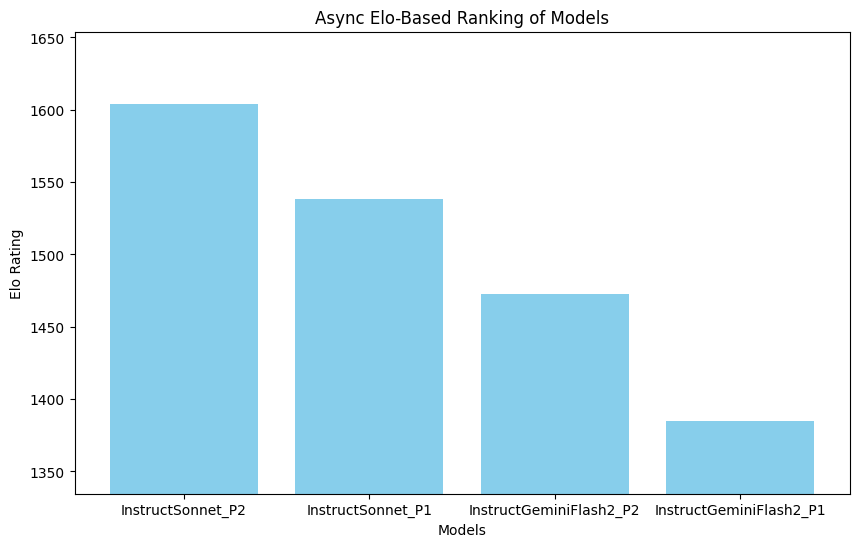

In [3]:

# This will load the Elo ratings from the file and plot them.
plot_ratings_from_file("elo_ratings_models_p1_vs_p2.json")

In [5]:
# Instantiate evaluation model.
evaluation_model = InstructSonnet(temperature=0.0, max_tokens=5000)

models = [
    "InstructGeminiFlash2_P0",
    "InstructGeminiFlash2_P1"
]

# Run the asynchronous Elo rating evaluation.
elo_ratings = await run_elo_rating_evaluation(
    evaluation_model,
    models=models,
    repetitions=3,
    evaluated_actors="Eliza"
)

# Save the resulting Elo ratings to a file (e.g., JSON format).
save_ratings_to_file(elo_ratings, "elo_ratings_p0_vs_p1.json")

Final Elo Ratings:
InstructGeminiFlash2_P1: 1641.61
InstructGeminiFlash2_P0: 1358.39


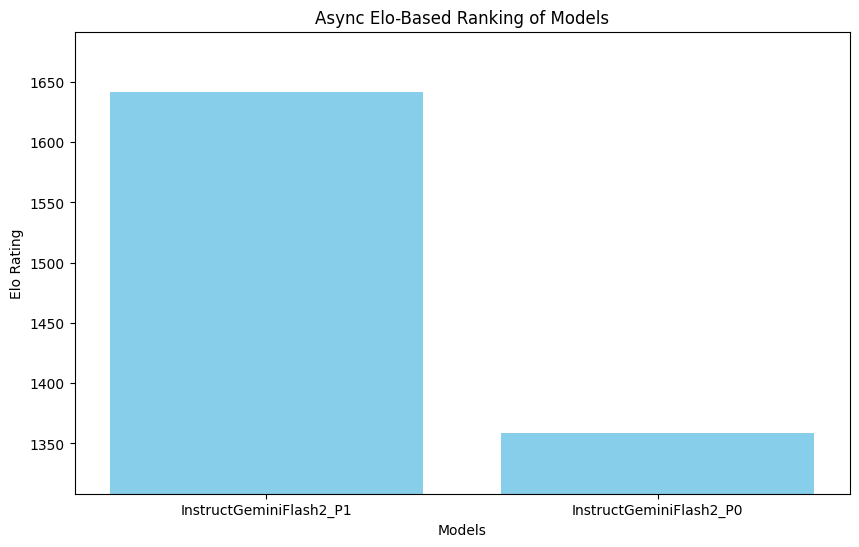

: 

In [6]:
# This will load the Elo ratings from the file and plot them.
plot_ratings_from_file("elo_ratings_p0_vs_p1.json")